# Functions / Libraries

In [2]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
from fetchData import fetchdata 

In [4]:
def train_test(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    print("Accuracy:\t\t",accuracy_score(y_test,result))
    print('Precision Score:\t', str(precision_score(y_test,result)))
    print('Recall Score:\t\t' + str(recall_score(y_test,result)))
    print("F1 Score:\t\t",f1_score(y_test, result, average='macro', zero_division=True))
    print(classification_report(y_test, result))
    

def valid(X_valid, y_valid, clf):
    clf.fit
    result = clf.predict(X_valid)
    print("Accuracy:",accuracy_score(result,y_valid))
    print(classification_report(y_valid, result))

def cv_events(data):
    NUM_EVENT = data.Event.unique().shape[0]
    EVENTS = data.Event.unique()

    cv_pd_list = []
    for i, d in enumerate(EVENTS):
        df1, df2 = [x for _, x in data.groupby(data['Event'] != d)]
        df1.reset_index(inplace=True, drop=True)
        df2.reset_index(inplace=True, drop=True)
        cv_pd_list.append([df1, df2])
    return cv_pd_list

def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [5]:
def scale_concat(data_list):
    scaler = StandardScaler()
    df = scaler.fit_transform(pd.concat(data_list, axis=1))
    return df

# Data

In [26]:
# Final
pheme_sparse_final = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_pos_final = pd.read_csv('./data/_PHEME_postags.csv')
pheme_thread_final_avg = pd.read_csv('./data/_PHEME_thread_avg.csv')
pheme_thread_final_std = pd.read_csv('./data/_PHEME_thread_std.csv')

ext_pos_final = pd.read_csv('./data/_PHEMEext_postags.csv')
ext_sparse_final = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_thread_final_avg = pd.read_csv('./data/_PHEMEext_thread_avg.csv')
ext_thread_final_std = pd.read_csv('./data/_PHEMEext_thread_std.csv')

pheme_bert_simple_normal = pd.read_csv('./data/_PHEME_Bert_final_simple_nrmzd.csv')
ext_bert_simple_normal = pd.read_csv('./data/_PHEMEext_Bert_final_simple_nrmzd.csv')

pheme_bert_brackets_normal = pd.read_csv('./data/_PHEME_Bert_final_brackets_nrmzd.csv')
ext_bert_brackets_normal = pd.read_csv('./data/_PHEMEext_Bert_final_brackets_nrmzd.csv')

pheme_event = pd.read_csv('./data/_PHEME_text.csv')['Event']
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event
pheme_AVGw2v = pd.read_csv('./data/_PHEME_text_AVGw2v_final.csv')
ext_AVGw2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v_final.csv')


In [27]:
pheme_root = pd.concat([pheme_sparse_final, pheme_pos_final],axis=1)
ext_root = pd.concat([ext_sparse_final, ext_pos_final],axis=1)

pheme_root_thread = pd.concat([pheme_root, pheme_thread_final_avg],axis=1)
ext_root_thread = pd.concat([ext_root, ext_thread_final_avg],axis=1)

pheme_total_bert= pd.concat([pheme_root_thread, pheme_bert_simple_normal],axis=1)
ext_total_bert = pd.concat([ext_root_thread, ext_bert_simple_normal],axis=1)
pheme_total_w2v= pd.concat([pheme_root_thread, pheme_AVGw2v],axis=1)
ext_total_w2v = pd.concat([ext_root_thread, ext_AVGw2v],axis=1)



pheme_w2v_bert = pd.concat([pheme_AVGw2v, pheme_bert_simple_normal],axis=1)
ext_w2v_bert = pd.concat([ext_AVGw2v, ext_bert_simple_normal],axis=1)

In [28]:
all_event = pd.concat([pheme_event,ext_event],axis=0, ignore_index=True)
all_y = pd.concat([pheme_y,ext_y],axis=0, ignore_index=True)

all_root = pd.concat([pheme_root, ext_root],axis=0, ignore_index=True)
all_thread = pd.concat([pheme_thread_final_avg, ext_thread_final_avg],axis=0, ignore_index=True)
all_bert_simple = pd.concat([pheme_bert_simple_normal,ext_bert_simple_normal],axis=0,ignore_index=True)
all_AVGw2v = pd.concat([pheme_AVGw2v,ext_AVGw2v],axis=0,ignore_index=True)
all_w2v_bert = pd.concat([pheme_w2v_bert,ext_w2v_bert],axis=0,ignore_index=True)
all_root_thread = pd.concat([pheme_root_thread,ext_root_thread],axis=0,ignore_index=True)
all_total_bert = pd.concat([pheme_total_bert,ext_total_bert],axis=0,ignore_index=True)
all_total_w2v = pd.concat([pheme_total_w2v,ext_total_w2v],axis=0,ignore_index=True)

In [25]:
all_total_w2v.shape

(6425, 301)

In [10]:
# cv = cv_events(pd.concat([pheme_sparse, pheme_event], axis=1))
# cv = cv_events(pd.concat([pheme_sparse, pheme_y, pheme_event],axis=1))

# Functions

In [9]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)

np.random.seed(42)
random.seed(42)

seed = 42

In [14]:
def process_cv(dataset, events=pheme_event, target=pheme_y, verbose=True):
    cv_pd_list = []
    data = pd.concat([dataset, pheme_event, pheme_y], axis=1)
    NUM_EVENT = data.Event.unique().shape[0]
    EVENTS = data.Event.unique()
    results = {}

    for i, d in enumerate(EVENTS):
        df1, df2 = [x for _, x in data.groupby(data['Event'] != d)]
        df1.reset_index(inplace=True, drop=True)
        df2.reset_index(inplace=True, drop=True)
        cv_pd_list.append([df2, df1])
    for index, fold in enumerate(cv_pd_list):
        train, test = fold
        print("FOLD %d\n----------------------------------------------------------------------------" % (int(index)+1))
        train_target = train.pop('target')
        train.pop('Event')
        test_target = test.pop('target')
        test.pop('Event')


In [29]:
ext_total_w2v.shape

(623, 301)

In [77]:
def cv_process(dataset, clfClass, target, events, verbose=True, scaling=False):

    # cv_pd_list[?][0]은 Training cv_pd_list[?][1] Testing
    cv_pd_list = []
    data = pd.concat([dataset, events, target], axis=1)
    NUM_EVENT = data.Event.unique().shape[0]
    EVENTS = data.Event.unique()
    results = {}
    # modelClass.__class__

    for i, d in enumerate(EVENTS):
        df1, df2 = [x for _, x in data.groupby(data['Event'] != d)]
        df1.reset_index(inplace=True, drop=True)
        df2.reset_index(inplace=True, drop=True)
        cv_pd_list.append([df2, df1])
    
    # for train, test in cv_pd_list:
    #     print("Train: %s \ Test: %s" % (train.shape, test.shape))

    # log = writeLog()
    modelname = clfClass.__name__
    PREFIX = "./Model/"+modelname+"_"
    # log.write(PREFIX+"log.txt",f"\nSTARTING TEST of {epochs} EPOCH\n")

    for index, fold in enumerate(cv_pd_list):

        # DATA PREPARATION
        train, test = fold
        # log.writeWithoutCR(PREFIX+"log.txt",f"\n----------------------------------------------------------------------------\n> FOLD {int(index)+1}\n----------------------------------------------------------------------------")
        print(f'> FOLD {int(index)+1}')
        train_target = train.pop('target')
        train.pop('Event').values
        test_target = test.pop('target')
        test.pop('Event')

        if scaling==True:
            scaler = StandardScaler()
            train = pd.DataFrame(scaler.fit_transform(train))
            test = pd.DataFrame(scaler.transform(test))

        train_size = int(train.shape[0])
        test_size = int(test.shape[0])

        model = clfClass()

        if verbose==True:
                # print("mean: %s, std: %s" % (data[0].mean(), data[0].std()))
                print("Train Size",train_size,"Test Size",test_size)

        model.fit(train, train_target)
        result = model.predict(test)

        acc = accuracy_score(test_target,result)
        f1 = f1_score(test_target,result, average='macro')
        if verbose==True:
            print("Accuracy:\t\t",acc)
            print('Precision Score:\t', str(precision_score(test_target,result)))
            print('Recall Score:\t\t' + str(recall_score(test_target,result)))
            print("F1 Score:\t\t",f1)
        # print(classification_report(test_target,result)

        results[index] = [acc*100, f1*100,train_size, test_size]

    return results

# Batch

In [52]:
result_list = []
result_mean_list = []

In [53]:
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [119]:
# ---------------------------------------------------------------------------- #
#                                  ROOT + POS                                  #
# ---------------------------------------------------------------------------- #

dataset = all_root
model = SVC

testing_results = []

result = cv_process(dataset, clfClass=model, events=all_event, target=all_y, verbose=True, scaling=True)
testing_results.append(result)

# writeLog().writeWithoutCR("./Model/"+root_model.__name__+"_"+"log.txt",f"RESULT:\n{epochs_diff(testing_results)}")
result_df = pd.DataFrame.from_dict(testing_results[0], orient='index', columns=['Acc', 'F1', 'Train_size','Test_size'])
result_df['Features'] = 'RP'
result_df['CV'] = 9
result_df['CLF'] = model.__name__

result_list.append(result_df)
CV_result_df = pd.DataFrame(result_df[['Acc','F1', 'CV']].mean(), columns=[result_df.Features[0]]).T
CV_result_df['CLF'] = result_df['CLF'][0]
result_mean_list.append(CV_result_df)

testing_results = []


> FOLD 1
Train Size 4346 Test Size 2079
Accuracy:		 0.7229437229437229
Precision Score:	 0.4206989247311828
Recall Score:		0.6834061135371179
F1 Score:		 0.6629703763911748
> FOLD 2
Train Size 5282 Test Size 1143
Accuracy:		 0.710411198600175
Precision Score:	 0.3769633507853403
Recall Score:		0.2535211267605634
F1 Score:		 0.5601929727687522
> FOLD 3
Train Size 5956 Test Size 469
Accuracy:		 0.6460554371002132
Precision Score:	 0.7068965517241379
Recall Score:		0.5168067226890757
F1 Score:		 0.6407490125143047
> FOLD 4
Train Size 5535 Test Size 890
Accuracy:		 0.6348314606741573
Precision Score:	 0.7821011673151751
Recall Score:		0.4276595744680851
F1 Score:		 0.6221576918504934
> FOLD 5
Train Size 5204 Test Size 1221
Accuracy:		 0.6764946764946765
Precision Score:	 0.673972602739726
Recall Score:		0.47126436781609193
F1 Score:		 0.650329699808234
> FOLD 6
Train Size 6411 Test Size 14
Accuracy:		 0.35714285714285715
Precision Score:	 1.0
Recall Score:		0.35714285714285715
F1 Score:		 

In [154]:
# ---------------------------------------------------------------------------- #
#                                  Thread                                  #
# ---------------------------------------------------------------------------- #

dataset = all_thread
model = SVC

testing_results = []

result = cv_process(dataset, clfClass=model, events=all_event, target=all_y, verbose=False, scaling=True)
testing_results.append(result)

# writeLog().writeWithoutCR("./Model/"+root_model.__name__+"_"+"log.txt",f"RESULT:\n{epochs_diff(testing_results)}")
result_df = pd.DataFrame.from_dict(testing_results[0], orient='index', columns=['Acc', 'F1', 'Train_size','Test_size'])
result_df['Features'] = 'Thread'
result_df['CV'] = 9
result_df['CLF'] = model.__name__

result_list.append(result_df)
CV_result_df = pd.DataFrame(result_df[['Acc','F1', 'CV']].mean(), columns=[result_df.Features[0]]).T
CV_result_df['CLF'] = result_df['CLF'][0]
result_mean_list.append(CV_result_df)

testing_results = []


> FOLD 1
> FOLD 2
> FOLD 3
> FOLD 4
> FOLD 5
> FOLD 6
> FOLD 7
> FOLD 8
> FOLD 9


In [153]:
# ---------------------------------------------------------------------------- #
#                                  w2v                                  #
# ---------------------------------------------------------------------------- #

dataset = all_AVGw2v
model = SVC

testing_results = []

result = cv_process(dataset, clfClass=model, events=all_event, target=all_y, verbose=False, scaling=True)
testing_results.append(result)

# writeLog().writeWithoutCR("./Model/"+root_model.__name__+"_"+"log.txt",f"RESULT:\n{epochs_diff(testing_results)}")
result_df = pd.DataFrame.from_dict(testing_results[0], orient='index', columns=['Acc', 'F1', 'Train_size','Test_size'])
result_df['Features'] = 'W2V'
result_df['CV'] = 9
result_df['CLF'] = model.__name__

result_list.append(result_df)
CV_result_df = pd.DataFrame(result_df[['Acc','F1', 'CV']].mean(), columns=[result_df.Features[0]]).T
CV_result_df['CLF'] = result_df['CLF'][0]
result_mean_list.append(CV_result_df)

testing_results = []


> FOLD 1
Train Size 4346 Test Size 2079
Accuracy:		 0.8258778258778259
Precision Score:	 0.5845070422535211
Recall Score:		0.7248908296943232
F1 Score:		 0.7657961954695167
> FOLD 2
Train Size 5282 Test Size 1143
Accuracy:		 0.7725284339457568
Precision Score:	 0.58
Recall Score:		0.30633802816901406
F1 Score:		 0.6302664450438434
> FOLD 3
Train Size 5956 Test Size 469
Accuracy:		 0.6886993603411514
Precision Score:	 0.7446808510638298
Recall Score:		0.5882352941176471
F1 Score:		 0.6860603726525822
> FOLD 4
Train Size 5535 Test Size 890
Accuracy:		 0.648314606741573
Precision Score:	 0.8284518828451883
Recall Score:		0.42127659574468085
F1 Score:		 0.6331414559241655
> FOLD 5
Train Size 5204 Test Size 1221
Accuracy:		 0.6764946764946765
Precision Score:	 0.7797356828193832
Recall Score:		0.3390804597701149
F1 Score:		 0.6196582645732802
> FOLD 6
Train Size 6411 Test Size 14
Accuracy:		 0.5714285714285714
Precision Score:	 1.0
Recall Score:		0.5714285714285714
F1 Score:		 0.36363636363

In [123]:
# ---------------------------------------------------------------------------- #
#                                  BERT                                  #
# ---------------------------------------------------------------------------- #

dataset = all_bert_simple
model = SVC
testing_results = []

result = cv_process(dataset, clfClass=model, events=all_event, target=all_y, verbose=False, scaling=True)
testing_results.append(result)

# writeLog().writeWithoutCR("./Model/"+root_model.__name__+"_"+"log.txt",f"RESULT:\n{epochs_diff(testing_results)}")
result_df = pd.DataFrame.from_dict(testing_results[0], orient='index', columns=['Acc', 'F1', 'Train_size','Test_size'])
result_df['Features'] = 'BERT'
result_df['CV'] = 9
result_df['CLF'] = model.__name__

result_list.append(result_df)
CV_result_df = pd.DataFrame(result_df[['Acc','F1', 'CV']].mean(), columns=[result_df.Features[0]]).T
CV_result_df['CLF'] = result_df['CLF'][0]
result_mean_list.append(CV_result_df)

testing_results = []


> FOLD 1
> FOLD 2
> FOLD 3
> FOLD 4
> FOLD 5
> FOLD 6
> FOLD 7
> FOLD 8
> FOLD 9


In [104]:
# ---------------------------------------------------------------------------- #
#                                  ROOT + POS + Thread                                  #
# ---------------------------------------------------------------------------- #

dataset = all_root_thread
model = GaussianNB


testing_results = []

result = cv_process(dataset, clfClass=model, events=all_event, target=all_y, verbose=False, scaling=True)
testing_results.append(result)

# writeLog().writeWithoutCR("./Model/"+root_model.__name__+"_"+"log.txt",f"RESULT:\n{epochs_diff(testing_results)}")
result_df = pd.DataFrame.from_dict(testing_results[0], orient='index', columns=['Acc', 'F1', 'Train_size','Test_size'])
result_df['Features'] = 'RPT'
result_df['CV'] = 9
result_df['CLF'] = model.__name__

result_list.append(result_df)
CV_result_df = pd.DataFrame(result_df[['Acc','F1', 'CV']].mean(), columns=[result_df.Features[0]]).T
CV_result_df['CLF'] = result_df['CLF'][0]
result_mean_list.append(CV_result_df)

testing_results = []


> FOLD 1
Train Size 4346 Test Size 2079
Accuracy:		 0.5377585377585378
Precision Score:	 0.30579150579150577
Recall Score:		0.8646288209606987
F1 Score:		 0.526106359991129
> FOLD 2
Train Size 5282 Test Size 1143
Accuracy:		 0.5660542432195975
Precision Score:	 0.24519230769230768
Recall Score:		0.3591549295774648
F1 Score:		 0.4893460637722933
> FOLD 3
Train Size 5956 Test Size 469
Accuracy:		 0.5181236673773987
Precision Score:	 0.5165745856353591
Recall Score:		0.7857142857142857
F1 Score:		 0.47734714003944767
> FOLD 4
Train Size 5535 Test Size 890
Accuracy:		 0.6404494382022472
Precision Score:	 0.6306620209059234
Recall Score:		0.7702127659574468
F1 Score:		 0.629351990671331
> FOLD 5
Train Size 5204 Test Size 1221
Accuracy:		 0.5773955773955773
Precision Score:	 0.5033557046979866
Recall Score:		0.8620689655172413
F1 Score:		 0.566334621865398
> FOLD 6
Train Size 6411 Test Size 14
Accuracy:		 0.8571428571428571
Precision Score:	 1.0
Recall Score:		0.8571428571428571
F1 Score:		 

In [129]:
# ---------------------------------------------------------------------------- #
#                                 W2V + RPT                                 #
# ---------------------------------------------------------------------------- #

dataset = all_total_w2v
model = SVC

testing_results = []

result = cv_process(dataset, clfClass=model, events=all_event, target=all_y, verbose=False, scaling=True)
testing_results.append(result)

# writeLog().writeWithoutCR("./Model/"+root_model.__name__+"_"+"log.txt",f"RESULT:\n{epochs_diff(testing_results)}")
result_df = pd.DataFrame.from_dict(testing_results[0], orient='index', columns=['Acc', 'F1', 'Train_size','Test_size'])
result_df['Features'] = 'RPT + W2V'
result_df['CV'] = 9
result_df['CLF'] = model.__name__

result_list.append(result_df)
CV_result_df = pd.DataFrame(result_df[['Acc','F1', 'CV']].mean(), columns=[result_df.Features[0]]).T
CV_result_df['CLF'] = result_df['CLF'][0]
result_mean_list.append(CV_result_df)

> FOLD 1
> FOLD 2
> FOLD 3
> FOLD 4
> FOLD 5
> FOLD 6
> FOLD 7
> FOLD 8
> FOLD 9


In [116]:
# ---------------------------------------------------------------------------- #
#                                 ALL Features                                 #
# ---------------------------------------------------------------------------- #

dataset = all_total_bert
model = SVC

testing_results = []

result = cv_process(dataset, clfClass=model, events=all_event, target=all_y, verbose=False, scaling=True)
testing_results.append(result)

# writeLog().writeWithoutCR("./Model/"+root_model.__name__+"_"+"log.txt",f"RESULT:\n{epochs_diff(testing_results)}")
result_df = pd.DataFrame.from_dict(testing_results[0], orient='index', columns=['Acc', 'F1', 'Train_size','Test_size'])
result_df['Features'] = 'RPT + BERT'
result_df['CV'] = 9
result_df['CLF'] = model.__name__

result_list.append(result_df)
CV_result_df = pd.DataFrame(result_df[['Acc','F1', 'CV']].mean(), columns=[result_df.Features[0]]).T
CV_result_df['CLF'] = result_df['CLF'][0]
result_mean_list.append(CV_result_df)

> FOLD 1
Train Size 4346 Test Size 2079
Accuracy:		 0.8335738335738335
Precision Score:	 0.6007194244604317
Recall Score:		0.7292576419213974
F1 Score:		 0.7743631148651702
> FOLD 2
Train Size 5282 Test Size 1143
Accuracy:		 0.7585301837270341
Precision Score:	 0.5714285714285714
Recall Score:		0.11267605633802817
F1 Score:		 0.5232029502448461
> FOLD 3
Train Size 5956 Test Size 469
Accuracy:		 0.652452025586354
Precision Score:	 0.7551020408163265
Recall Score:		0.46638655462184875
F1 Score:		 0.6409337497945091
> FOLD 4
Train Size 5535 Test Size 890
Accuracy:		 0.7573033707865169
Precision Score:	 0.8207070707070707
Recall Score:		0.6914893617021277
F1 Score:		 0.7571267580010208
> FOLD 5
Train Size 5204 Test Size 1221
Accuracy:		 0.7264537264537264
Precision Score:	 0.7385786802030457
Recall Score:		0.5574712643678161
F1 Score:		 0.7082491543951421
> FOLD 6
Train Size 6411 Test Size 14
Accuracy:		 0.6428571428571429
Precision Score:	 1.0
Recall Score:		0.6428571428571429
F1 Score:		

# Result

In [155]:
final_result = pd.concat(result_list)
final_result.to_csv('./data/final_result_trad.csv')
final_result = pd.read_csv('./data/final_result_trad.csv', index_col=['Unnamed: 0'])
final_result

,Acc,F1,Train_size,Test_size,Features,CV,CLF
0,74.170274,66.476049,4346,2079,RP,9,RandomForestClassifier
1,73.928259,50.874870,5282,1143,RP,9,RandomForestClassifier
2,67.590618,67.590471,5956,469,RP,9,RandomForestClassifier
3,58.314607,54.586528,5535,890,RP,9,RandomForestClassifier
4,65.356265,59.023627,5204,1221,RP,9,RandomForestClassifier
...,...,...,...,...,...,...,...
4,61.588862,52.419810,5204,1221,Thread,9,SVC
5,71.428571,41.666667,6411,14,Thread,9,SVC
6,35.193133,26.532189,6192,233,Thread,9,SVC
7,57.142857,54.631083,6187,238,Thread,9,SVC


In [156]:
final_cv = pd.concat(result_mean_list)
final_cv.to_csv('./data/final_cv_trad.csv')
final_cv = pd.read_csv('./data/final_cv_trad.csv', index_col=['Unnamed: 0'])
final_cv

,Acc,F1,CV,CLF
RP,59.585615,48.260343,9.0,RandomForestClassifier
RP,60.199755,48.327515,9.0,RandomForestClassifier
RP,60.199755,48.327515,9.0,RandomForestClassifier
RP,55.988184,51.986107,9.0,LogisticRegression
RP,56.539407,52.078453,9.0,SVC
RP,59.963892,52.372452,9.0,GaussianNB
thread,59.300732,45.718719,9.0,RandomForestClassifier
W2V,52.757742,47.164008,9.0,RandomForestClassifier
BERT,53.409970,47.769311,9.0,RandomForestClassifier
RPT,59.409867,46.771044,9.0,RandomForestClassifier


In [157]:
final_cv.loc[final_cv.CLF == 'RandomForestClassifier']

,Acc,F1,CV,CLF
RP,59.585615,48.260343,9.0,RandomForestClassifier
RP,60.199755,48.327515,9.0,RandomForestClassifier
RP,60.199755,48.327515,9.0,RandomForestClassifier
thread,59.300732,45.718719,9.0,RandomForestClassifier
W2V,52.757742,47.164008,9.0,RandomForestClassifier
BERT,53.409970,47.769311,9.0,RandomForestClassifier
RPT,59.409867,46.771044,9.0,RandomForestClassifier
RPT + BERT,56.411103,51.820143,9.0,RandomForestClassifier


In [158]:
final_cv.loc[final_cv.CLF == 'GaussianNB']

,Acc,F1,CV,CLF
RP,59.963892,52.372452,9.0,GaussianNB
RP,59.963892,52.372452,9.0,GaussianNB
Thread,59.404906,46.335935,9.0,GaussianNB
W2V,59.440297,54.106923,9.0,GaussianNB
BERT,60.029846,56.775122,9.0,GaussianNB
RPT,59.188564,48.386503,9.0,GaussianNB
RPT + W2V,63.814826,55.708365,9.0,GaussianNB
RPT + BERT,61.619751,57.716726,9.0,GaussianNB


In [159]:
final_cv.loc[final_cv.CLF == 'SVC']

,Acc,F1,CV,CLF
RP,56.539407,52.078453,9.0,SVC
RPT + BERT,63.160145,55.693573,9.0,SVC
RP,56.539407,52.078453,9.0,SVC
BERT,60.753041,52.189512,9.0,SVC
RPT + W2V,62.337890,55.221933,9.0,SVC
W2V,59.486649,52.228986,9.0,SVC
Thread,57.417532,46.714669,9.0,SVC


# Feature Importance on Sparse Features

Feature ranking:
1. feature 25: capital_ratio (0.022929)
2. feature 28: tweet_count (0.022486)
3. feature 13: Numeral (0.021493)
4. feature 31: follower_count (0.020663)
5. feature 5: Noun (0.020122)
6. feature 29: listed_count (0.019489)
7. feature 6: Verb (0.018645)
8. feature 65: AVG FPP (0.017962)
9. feature 32: followers/friend (0.017806)
10. feature 33: favourites_count (0.017505)
11. feature 20: word_count (0.017440)
12. feature 3: Skepticism (0.017433)
13. feature 16: Determiner (0.017349)
14. feature 7: Adjective (0.017347)
15. feature 34: account_age_days (0.017262)
16. feature 19: char_count (0.017011)
17. feature 71: AVG Skepticism (0.016744)
18. feature 66: STD FPP (0.016599)
19. feature 21: HashTag (0.016599)
20. feature 68: STD SPP (0.016549)
21. feature 69: AVG TPP (0.016370)
22. feature 8: Pronoun (0.016242)
23. feature 30: friends_count (0.016239)
24. feature 35: verified (0.016109)
25. feature 67: AVG SPP (0.016017)
26. feature 14: Conjunction_inj (0.015892)
27. feat

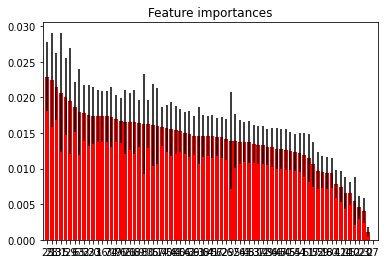

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
scaler = StandardScaler()
X = scaler.fit_transform(pheme_sparse)
X2 = scaler.fit_transform(pheme_thread)

X = pd.concat([pheme_sparse, pheme_thread], axis=1)

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=3)

forest.fit(X, pheme_y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
Feature ranking:
1. feature 25: capital_ratio (0.023554)
2. feature 29: listed_count (0.023047)
3. feature 28: tweet_count (0.022576)
4. feature 13: Numeral (0.022373)
5. feature 31: follow_ratio (0.021648)
6. feature 5: Noun (0.020772)
7. feature 6: Verb (0.018965)
8. feature 30: friends_count (0.018720)
9. feature 7: Adjective (0.018711)
10. feature 32: account_age_days (0.018371)
11. feature 3: Skepticism (0.018333)
12. feature 63: AVG FPP (0.018230)
13. feature 16: Determiner (0.018211)
14. feature 20: word_count (0.017997)
15. feature 19: char_count (0.017476)
16. feature 64: STD FPP (0.017206)
17. feature 67: AVG TPP (0.017082)
18. feature 69: AVG Skepticism (0.017057)
19. feature 21: HashTag (0.016944)
20. feature 65: AVG SPP (0.016567)
21. feature 56: thread_time (0.016411)
22. feature 66: STD SPP (0.016360)
23. feature 14: Conjunction_inj (0.016151)
24. feature 68: STD TPP (0.016145)
25. feature 41: Ratio HashTag (0.016090)
26. feature 38: AVG CharCount (0.015695)
27. feature 8: Pronoun (0.015674)
28. feature 54: AVG AccAge (0.015432)
29. feature 37: AVG WordCount (0.015418)
30. feature 40: SUM HashTag (0.015303)
31. feature 33: verified (0.015233)
32. feature 36: AVG FriendsCount (0.015208)
33. feature 9: FirstPersonPronoun (0.015171)
34. feature 62: RATIO Period (0.015147)
35. feature 59: Ratio Media (0.015048)
36. feature 39: AVG HashTag (0.014982)
37. feature 60: RATIO Question (0.014928)
38. feature 55: STD AccAge (0.014914)
39. feature 26: retweet_count (0.014715)
40. feature 51: SUM RT (0.014321)
41. feature 52: AVG RT (0.014225)
42. feature 46: AVG Mention (0.014223)
43. feature 61: RATIO Exclaim (0.014075)
44. feature 2: has_media (0.013751)
45. feature 35: SUM FriendsCount (0.013744)
46. feature 47: Ratio Mention (0.013624)
47. feature 12: Adverb (0.013606)
48. feature 34: depth (0.013599)
49. feature 53: STD RT (0.013502)
50. feature 44: RATIO Url (0.013118)
51. feature 48: Tweets Count (0.013090)
52. feature 45: SUM Mention (0.013022)
53. feature 43: STD Url (0.012792)
54. feature 42: AVG Url (0.012651)
55. feature 1: URLcount (0.012328)
56. feature 49: Ratio Verified (0.011846)
57. feature 17: Modal (0.010733)
58. feature 50: SUM Verified (0.010200)
59. feature 18: Whs (0.009731)
60. feature 57: STD Emoji (0.009702)
61. feature 58: AVG Emoji (0.009570)
62. feature 4: MentionCount (0.008058)
63. feature 11: ThirdPersonPronoun (0.007592)
64. feature 24: has_period (0.006844)
65. feature 15: Particle (0.006585)
66. feature 10: SecondPersonPronoun (0.005497)
67. feature 22: has_question (0.004690)
68. feature 23: has_exclaim (0.004280)
69. feature 0: emoji_count (0.001138)
70. feature 27: isRT (0.000000

Feature ranking:
1. feature 25: capital_ratio (0.023554)
2. feature 29: listed_count (0.023047)
3. feature 28: tweet_count (0.022576)
4. feature 13: Numeral (0.022373)
5. feature 31: follow_ratio (0.021648)
6. feature 5: Noun (0.020772)
7. feature 6: Verb (0.018965)
8. feature 30: friends_count (0.018720)
9. feature 7: Adjective (0.018711)
10. feature 32: account_age_days (0.018371)
11. feature 3: Skepticism (0.018333)
12. feature 63: AVG FPP (0.018230)
13. feature 16: Determiner (0.018211)
14. feature 20: word_count (0.017997)
15. feature 19: char_count (0.017476)
16. feature 64: STD FPP (0.017206)
17. feature 67: AVG TPP (0.017082)
18. feature 69: AVG Skepticism (0.017057)
19. feature 21: HashTag (0.016944)
20. feature 65: AVG SPP (0.016567)
21. feature 56: thread_time (0.016411)
22. feature 66: STD SPP (0.016360)
23. feature 14: Conjunction_inj (0.016151)
24. feature 68: STD TPP (0.016145)
25. feature 41: Ratio HashTag (0.016090)
26. feature 38: AVG CharCount (0.015695)
27. feature 

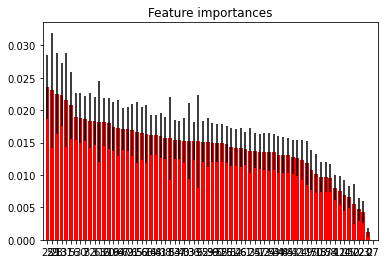

In [7]:
from sklearn.ensemble import ExtraTreesClassifier
scaler = StandardScaler()
X = scaler.fit_transform(pheme_sparse)
X2 = scaler.fit_transform(pheme_thread)

X = pd.concat([pheme_sparse, pheme_thread], axis=1)

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=3)

forest.fit(X, pheme_y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Thread

In [15]:
process_cv(pheme_thread)

FOLD 1
----------------------------------------------------------------------------
FOLD 2
----------------------------------------------------------------------------
FOLD 3
----------------------------------------------------------------------------
FOLD 4
----------------------------------------------------------------------------
FOLD 5
----------------------------------------------------------------------------


In [44]:
scaler = StandardScaler()
X_train = scaler.fit_transform(pheme_thread.values)
X_test = scaler.fit_transform(ext_thread.values)

In [46]:
clf = SVC()
train_test(X_train, X_test, pheme_y, ext_y, clf)

# Accuracy:		 0.6268041237113402
# Precision Score:	 0.7596685082872928
# Recall Score:		0.7452574525745257
# F1 Score:		 0.49753590255796776

Accuracy:		 0.24123711340206186
Precision Score:	 1.0
Recall Score:		0.0027100271002710027
F1 Score:		 0.19603603603603603
              precision    recall  f1-score   support

           0       0.24      1.00      0.39       116
           1       1.00      0.00      0.01       369

    accuracy                           0.24       485
   macro avg       0.62      0.50      0.20       485
weighted avg       0.82      0.24      0.10       485



# Sparse

## Data

In [8]:
scaler = StandardScaler()
pheme_sparse_scaled = scaler.fit_transform(pheme_sparse.values)
ext_sparse_scaled = scaler.fit_transform(ext_sparse.values)

## CLF

In [9]:
clf = SVC(gamma='auto')
train_test(pheme_sparse_scaled, ext_sparse_scaled, pheme_y, ext_y, clf)

Accuracy:		 0.354639175257732
Precision Score:	 0.9242424242424242
Recall Score:		0.16531165311653118
F1 Score:		 0.34770652057149
              precision    recall  f1-score   support

           0       0.26      0.96      0.41       116
           1       0.92      0.17      0.28       369

    accuracy                           0.35       485
   macro avg       0.59      0.56      0.35       485
weighted avg       0.77      0.35      0.31       485



In [10]:
clf = GaussianNB()
train_test(pheme_sparse_scaled, ext_sparse_scaled, pheme_y, ext_y, clf)

Accuracy:		 0.6371134020618556
Precision Score:	 0.8205980066445183
Recall Score:		0.6693766937669376
F1 Score:		 0.5753233830845771
              precision    recall  f1-score   support

           0       0.34      0.53      0.41       116
           1       0.82      0.67      0.74       369

    accuracy                           0.64       485
   macro avg       0.58      0.60      0.58       485
weighted avg       0.70      0.64      0.66       485



## SPARSE - PHEME CV

In [37]:
X = cv[3][1].drop(['target', 'Event'],axis=1)
y = cv[3][1].target
val_X = cv[3][0].drop(['target', 'Event'],axis=1)
val_y = cv[3][0].target
clf = SVC(gamma='auto')
train_test(X, val_X, y, val_y, clf)
# valid(rhi, rhi_y, clf)

Accuracy:		 0.47191011235955055
Precision Score:	 0.0
Recall Score:		0.0
F1 Score:		 0.32061068702290074
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       420
           1       0.00      0.00      0.00       470

    accuracy                           0.47       890
   macro avg       0.24      0.50      0.32       890
weighted avg       0.22      0.47      0.30       890



/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/june/m

# Sparse + W2V

## Data

In [41]:
scaler = StandardScaler()
df = scaler.fit_transform(pheme_sparse.values)
sparse_w2v = np.concatenate([df, pheme_AVGw2v.values],axis=1)
df = scaler.fit_transform(ext_sparse.values)
sparse_w2v_ext = np.concatenate([df, ext_AVGw2v.values],axis=1)

## CLF

In [84]:
clf = SVC(gamma='auto')
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

NameError: name 'sparse_w2v' is not defined

In [45]:
clf = GaussianNB()
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

Accuracy:		 0.4
Precision Score:	 0.9148936170212766
Recall Score:		0.23306233062330622
F1 Score:		 0.3987628918680588
              precision    recall  f1-score   support

           0       0.28      0.93      0.43       116
           1       0.91      0.23      0.37       369

    accuracy                           0.40       485
   macro avg       0.60      0.58      0.40       485
weighted avg       0.76      0.40      0.38       485



# BERT

## Data

In [17]:
# pheme_y.head()
pheme_bert.head()

,BERTEmbed_0,BERTEmbed_1,BERTEmbed_2,BERTEmbed_3,BERTEmbed_4,BERTEmbed_5,BERTEmbed_6,BERTEmbed_7,BERTEmbed_8,BERTEmbed_9,...,BERTEmbed_758,BERTEmbed_759,BERTEmbed_760,BERTEmbed_761,BERTEmbed_762,BERTEmbed_763,BERTEmbed_764,BERTEmbed_765,BERTEmbed_766,BERTEmbed_767
0,0.299457,0.198897,-0.491295,0.211787,0.197080,0.234026,0.200608,-0.096086,0.250423,0.266876,...,0.209932,-0.166056,0.245046,-0.580443,-0.141690,0.222918,-0.144328,0.048243,-0.027414,-0.055394
1,0.299628,0.207495,-0.491100,0.207046,0.198606,0.223802,0.201070,-0.085390,0.272306,0.276768,...,0.227522,-0.168281,0.246145,-0.575933,-0.133583,0.210461,-0.141031,0.049042,-0.035745,-0.065774
2,0.300907,0.193260,-0.498778,0.215972,0.193097,0.223985,0.181815,-0.106533,0.247362,0.262557,...,0.210722,-0.168287,0.242233,-0.579043,-0.142183,0.223372,-0.142068,0.043969,-0.031963,-0.054336
3,0.294519,0.198307,-0.492020,0.211912,0.201571,0.225530,0.192947,-0.100199,0.261141,0.264648,...,0.216593,-0.163219,0.242032,-0.586569,-0.137623,0.219293,-0.139870,0.039641,-0.034909,-0.062468
4,0.296625,0.196416,-0.493361,0.214012,0.195244,0.231359,0.194209,-0.101270,0.252890,0.263173,...,0.211895,-0.166441,0.237079,-0.587006,-0.140724,0.224566,-0.142844,0.041942,-0.030708,-0.056173


## CLF

In [72]:
clf = SVC(gamma='auto')
train_test(pheme_bert, ext_bert, pheme_y, ext_y, clf)

Accuracy:		 0.5917525773195876
Precision Score:	 0.7697160883280757
Recall Score:		0.6612466124661247
F1 Score:		 0.5070935818995606
              precision    recall  f1-score   support

           0       0.26      0.37      0.30       116
           1       0.77      0.66      0.71       369

    accuracy                           0.59       485
   macro avg       0.51      0.52      0.51       485
weighted avg       0.65      0.59      0.61       485



In [83]:
clf = GaussianNB()
train_test(pheme_bert, ext_bert, pheme_y, ext_y, clf)

Accuracy:		 0.6268041237113402
Precision Score:	 0.7596685082872928
Recall Score:		0.7452574525745257
F1 Score:		 0.49753590255796776
              precision    recall  f1-score   support

           0       0.24      0.25      0.24       116
           1       0.76      0.75      0.75       369

    accuracy                           0.63       485
   macro avg       0.50      0.50      0.50       485
weighted avg       0.63      0.63      0.63       485



# W2V

## Data

## CLF

In [84]:
clf = SVC(gamma='auto')
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

Accuracy:		 0.32989690721649484
Precision Score:	 0.9782608695652174
Recall Score:		0.12195121951219512
F1 Score:		 0.31564094214696625
              precision    recall  f1-score   support

           0       0.26      0.99      0.41       116
           1       0.98      0.12      0.22       369

    accuracy                           0.33       485
   macro avg       0.62      0.56      0.32       485
weighted avg       0.81      0.33      0.26       485



In [85]:
clf = GaussianNB()
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

Accuracy:		 0.4
Precision Score:	 0.9148936170212766
Recall Score:		0.23306233062330622
F1 Score:		 0.3987628918680588
              precision    recall  f1-score   support

           0       0.28      0.93      0.43       116
           1       0.91      0.23      0.37       369

    accuracy                           0.40       485
   macro avg       0.60      0.58      0.40       485
weighted avg       0.76      0.40      0.38       485



# BERT + SPARSE

## Data

In [38]:
scaler = StandardScaler()
df = scaler.fit_transform(pheme_sparse.values)
df2 = scaler.fit_transform(pheme_thread.values)
sparse_bert = np.concatenate([df, df2, pheme_bert.values],axis=1)
df = scaler.fit_transform(ext_sparse.values)
df2 = scaler.fit_transform(ext_thread.values)
sparse_bert_ext = np.concatenate([df, df2, ext_bert.values],axis=1)

## CLF

In [39]:
clf = SVC(gamma='auto')
train_test(sparse_bert, sparse_bert_ext, pheme_y, ext_y, clf)

Accuracy:		 0.4350515463917526
Precision Score:	 0.8925619834710744
Recall Score:		0.2926829268292683
F1 Score:		 0.43499149659863945
              precision    recall  f1-score   support

           0       0.28      0.89      0.43       116
           1       0.89      0.29      0.44       369

    accuracy                           0.44       485
   macro avg       0.59      0.59      0.43       485
weighted avg       0.75      0.44      0.44       485



In [37]:
clf = GaussianNB()
train_test(sparse_bert, sparse_bert_ext, pheme_y, ext_y, clf)

# Accuracy:		 0.6268041237113402
# Precision Score:	 0.7596685082872928
# Recall Score:		0.7452574525745257
# F1 Score:		 0.49753590255796776

Accuracy:		 0.6268041237113402
Precision Score:	 0.7596685082872928
Recall Score:		0.7452574525745257
F1 Score:		 0.49753590255796776
              precision    recall  f1-score   support

           0       0.24      0.25      0.24       116
           1       0.76      0.75      0.75       369

    accuracy                           0.63       485
   macro avg       0.50      0.50      0.50       485
weighted avg       0.63      0.63      0.63       485



In [13]:
X = scale_concat([pheme_sparse, pheme_bert])
X2 = scale_concat([ext_sparse, ext_bert])
clf = GaussianNB()
train_test(X, sparse_bert_ext, pheme_y, ext_y, clf)

Accuracy:		 0.6536082474226804
Precision Score:	 0.7570332480818415
Recall Score:		0.8021680216802168
F1 Score:		 0.48947368421052634
              precision    recall  f1-score   support

           0       0.22      0.18      0.20       116
           1       0.76      0.80      0.78       369

    accuracy                           0.65       485
   macro avg       0.49      0.49      0.49       485
weighted avg       0.63      0.65      0.64       485



In [35]:
X = scale_concat([pheme_sparse, pheme_bert, pheme_thread])
X2 = scale_concat([ext_sparse, ext_bert, ext_thread])
clf = SVC()
train_test(X, X2, pheme_y, ext_y, clf)

Accuracy:		 0.5051546391752577
Precision Score:	 0.8028169014084507
Recall Score:		0.4634146341463415
F1 Score:		 0.4845360824742268
              precision    recall  f1-score   support

           0       0.27      0.64      0.38       116
           1       0.80      0.46      0.59       369

    accuracy                           0.51       485
   macro avg       0.54      0.55      0.48       485
weighted avg       0.68      0.51      0.54       485

